# Evaluate different CNN models over MPI and Era

This notebook evaluates different CNN autoencoder models on things like 1) monthly averages and 2) climate. The selected model tries to bias correct Mpi to Era and Era to MPI.

### TOC
 
 [4. Disciminator label swap](#ds)<br>
 
 





In [700]:
from IPython import display

import numpy as np
import torch
from torch import nn
bce = nn.BCELoss()
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


In [3]:
# define internal pic res
ires = 128
res = 128
nvars = 16
mnvars = 16


In [4]:
 mnvars

16

<a id='ms'></a>
## Models: run one from below:


In [5]:
import torch.nn.functional as F

In [1925]:
# Variational autoencoder
# Dependency: run the cell above

class VGG13Gen(torch.nn.Module):
    def __init__(self):
        super(VGG13Gen, self).__init__()

        #self.conv1_1 = nn.Conv2d(64, 64, 3, padding=1)
        #self.conv11_bn = nn.BatchNorm2d(64)
        #self.conv1_2 = nn.Conv2d(64, 16, 3, padding=1)
        #self.conv12_bn = nn.BatchNorm2d(16)

        self.conv2_1 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv21_bn = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 16, 3, padding=1)
        self.conv22_bn = nn.BatchNorm2d(16)

        self.conv3_1 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv31_bn = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv32_bn = nn.BatchNorm2d(128)
        self.conv3_3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv33_bn = nn.BatchNorm2d(64)

        self.conv4_1 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv41_bn = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv42_bn = nn.BatchNorm2d(256)
        self.conv4_3 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv43_bn = nn.BatchNorm2d(128)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv51_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv52_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv53_bn = nn.BatchNorm2d(256)

    def reparameterize(self, mu, var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        #std = torch.exp(0.5*log_var) # standard deviation
        #eps = torch.randn_like(std) # `randn_like` as we need the same size
        #sample = mu + (eps * std) # sampling as if coming from the input space

        print('mu', mu)
        print('var', var)
        std = var.std((0)) # standard deviation along 0 axis
        print(std)
        eps = torch.normal(0, std).view(1, 256, 4, 4)
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
        # get `mu` and `log_var`
        mu = x[:, 0:256, :, :] # the first feature values as mean
        var = x[:, 256:512, :, :] # the other feature values as variance

        # get the latent vector through reparameterization
        #z = self.reparameterize(mu, var)
        z = mu

        pixel_shuffle = nn.PixelShuffle(2)
        #x = pixel_shuffle(x.repeat(1,4,1,1))
        x = pixel_shuffle(z.repeat(1,8,1,1))
        x = F.leaky_relu(self.conv51_bn(self.conv5_1(x)))
        x = F.leaky_relu(self.conv52_bn(self.conv5_2(x)))
        x = F.leaky_relu(self.conv53_bn(self.conv5_3(x)))

        x = pixel_shuffle(x.repeat(1,4,1,1))
        x = F.leaky_relu(self.conv41_bn(self.conv4_1(x)))
        x = F.leaky_relu(self.conv42_bn(self.conv4_2(x)))
        x = F.leaky_relu(self.conv43_bn(self.conv4_3(x)))

        x = pixel_shuffle(x.repeat(1,4,1,1))
        x = F.leaky_relu(self.conv31_bn(self.conv3_1(x)))
        x = F.leaky_relu(self.conv32_bn(self.conv3_2(x)))
        x = F.leaky_relu(self.conv33_bn(self.conv3_3(x)))

        x = pixel_shuffle(x.repeat(1,4,1,1))
        x = F.leaky_relu(self.conv21_bn(self.conv2_1(x)))
        x = F.sigmoid(self.conv2_2(x))
        #x = F.leaky_relu(self.conv22_bn(self.conv2_2(x)))

        #x = pixel_shuffle(x.repeat(1,4,1,1))
        #x = F.leaky_relu(self.conv11_bn(self.conv1_1(x)))
        ##x = F.sigmoid(self.conv12_bn(self.conv1_2(x)))
        #x = F.leaky_relu(self.conv12_bn(self.conv1_2(x)))
        return x #, mu, var
    
class VGG16_D(torch.nn.Module):
  def __init__(self):
    super(VGG16_D, self).__init__()

    # construct model: Conv2d(16, 64, 3, 1, 1)
    #self.conv1_1 = nn.Conv2d(16, 64, 3, padding=1)
    #self.conv11_bn = nn.BatchNorm2d(64)
    #self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
    #self.conv12_bn = nn.BatchNorm2d(64)
    self.conv2_1 = nn.Conv2d(16, 64, 3, padding=1)
    self.conv21_bn = nn.BatchNorm2d(64)
    self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv22_bn = nn.BatchNorm2d(64)
    self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv31_bn = nn.BatchNorm2d(128)
    self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv32_bn = nn.BatchNorm2d(128)
    self.conv3_3 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv33_bn = nn.BatchNorm2d(128)
    self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv41_bn = nn.BatchNorm2d(256)
    self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv42_bn = nn.BatchNorm2d(256)
    self.conv4_3 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv43_bn = nn.BatchNorm2d(256)
    self.conv5_1 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv51_bn = nn.BatchNorm2d(256)
    self.conv5_2 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv52_bn = nn.BatchNorm2d(256)
    self.conv5_3 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv53_bn = nn.BatchNorm2d(256)

    #self.fc6 = nn.Linear(8192/2, 512)

  def forward(self, x):
    #m = nn.Dropout(p=0.5)
    ##m = nn.Dropout(p=0)
    #x = m(x)

    #x = F.leaky_relu(self.conv11_bn(self.conv1_1(x)))
    #x = F.leaky_relu(self.conv12_bn(self.conv1_2(x)))
    #x = F.avg_pool2d(x, (2, 2))

    x = F.leaky_relu(self.conv22_bn(self.conv2_1(x)))
    x = F.leaky_relu(self.conv21_bn(self.conv2_2(x)))
    x = F.avg_pool2d(x, (2, 2))

    x = F.leaky_relu(self.conv31_bn(self.conv3_1(x)))
    x = F.leaky_relu(self.conv32_bn(self.conv3_2(x)))
    x = F.leaky_relu(self.conv33_bn(self.conv3_3(x)))
    x = F.avg_pool2d(x, (2, 2))

    x = F.leaky_relu(self.conv41_bn(self.conv4_1(x)))
    x = F.leaky_relu(self.conv42_bn(self.conv4_2(x)))
    x = F.leaky_relu(self.conv43_bn(self.conv4_3(x)))
    x = F.avg_pool2d(x, (2, 2))

    x = F.leaky_relu(self.conv51_bn(self.conv5_1(x)))
    x = F.leaky_relu(self.conv52_bn(self.conv5_2(x)))
    x = F.leaky_relu(self.conv53_bn(self.conv5_3(x)))
    x = F.avg_pool2d(x, (2, 2))

    #print('x', x.shape)
    x = F.sigmoid(x.view(-1, 4096))
    #print('xx', x.shape)

    ##x = F.sigmoid(self.fc6(x))
    #x = self.fc6(x)

    #x = F.leaky_relu(self.fc7(x))
    #x = F.leaky_relu(self.fc8(x))
    #print('xxx', x.shape)
    return x

    
    

# general encoder
general_encoder = VGG13(1000)
#gstate = torch.load("/glade/scratch/dkorytin/saved_models/vgg13x2x64var-patch-ganbce5z-eraandmpiext-with-orog-doy-cuda_generator-e800", map_location=torch.device('cpu'))
#gstate = torch.load("/glade/scratch/dkorytin/saved_models/vgg13x2x64var-patch-ganbce5z-eraandmpiext-with-orog-doy-cuda_generator-e250", map_location=torch.device('cpu'))
#gstate = torch.load("/glade/scratch/dkorytin/saved_models/vgg13x2x64var-patch-ganbce5z-eraandmpiext-with-orog-doy-cuda_generator-e600", map_location=torch.device('cpu'))
gstate = torch.load("/glade/scratch/dkorytin/saved_models/vgg13x2x64var-patch-ganbce5z-eraandmpiext-with-orog-doy-cuda_generator-e350", map_location=torch.device('cpu'))

# general_encoder.load_state_dict(gstate['encoder'])
# general_encoder.eval()

# minmaxi_era = np.array(gstate['minmaxi_era'])
# minmaxi_mpi = minmaxi_era    # same normalization scale

# # bottleneck
# bottleneck = Bottleneck()
# bottleneck.load_state_dict(gstate['bottleneck'])
# bottleneck.eval()


# # vgg16 decoder
# vgg_decoder = VGG13Gen()
# vgg_decoder.load_state_dict(gstate['generator2'])
# vgg_decoder.eval()

# # load xfer decoder
# xfer_decoder = VGG13Gen()
# xfer_decoder.load_state_dict(gstate['generator'])
# xfer_decoder.eval()

# discriminator_era
discriminator_era = VGG16_D()
discriminator_era.load_state_dict(gstate['discriminator_era'])
discriminator_era.eval()



VGG16_D(
  (conv2_1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41_bn): BatchNorm2d(256, 

In [744]:
6

6

<a id='ld'></a>
# Load data

In [709]:
# gridmet as mask: small domaim
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(23.0,55.0), lon=slice(-112.7,-80.8))   # shifted 1 pixel up
#mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(23.375,55.2), lon=slice(-112.7,-80.8))
#mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))

mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.


In [710]:
mask.shape

(128, 128)

In [1414]:
# load numpy file: extended domain
samples_mpi = torch.tensor(np.load('/glade/scratch/dkorytin/samples_mpiext_with_orog_1095.npy'), dtype=torch.float32)
samples_era = torch.tensor(np.load('/glade/scratch/dkorytin/samples_eraext_with_orog_1095.npy'), dtype=torch.float32)
minmaxi_era = np.load('/glade/scratch/dkorytin/minmaxi_eraext_with_orog.npy')
minmaxi_mpi = minmaxi_era

# gridmet as mask
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))
mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.

# zero out mask borders in surface vars
samples_mpi[:,8:,:,:] = samples_mpi[:,8:,:,:] * mask[None,None,:,:]
samples_era[:,8:,:,:] = samples_era[:,8:,:,:] * mask[None,None,:,:]


In [1528]:
# load numpy file
samples_mpi = torch.tensor(np.load('/glade/scratch/dkorytin/samples_mpiext_with_orog_1095.npy'), dtype=torch.float32)
samples_era = torch.tensor(np.load('/glade/scratch/dkorytin/samples_eraext_with_orog_1095.npy'), dtype=torch.float32)
minmaxi_era = np.load('/glade/scratch/dkorytin/minmaxi_eraext_with_orog.npy')
minmaxi_mpi = minmaxi_era

# zero out mask borders in surface vars
samples_mpi[:,8:,:,:] = samples_mpi[:,8:,:,:] * mask[None,None,:,:]
samples_era[:,8:,:,:] = samples_era[:,8:,:,:] * mask[None,None,:,:]


# Plot routines

## 64x64 Plot routines

In [1707]:
def plot_64x64_8v_abs_surf(isample, modelname, vmin, vmax, yoff, xoff, cc=True):

    varmames = ['prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'miss', 'yday']
    units = ['mm/day', 'C', 'C', 'm/s', 'm/s', 'kg/kg', '0..1', '0..1']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['BrBG', 'RdBu_r', 'RdBu_r', 'PiYG', 'PuOr', 'BrBG', 'Spectral', 'Spectral']
    #cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    cmaps = ['YlGnBu', 'coolwarm', 'coolwarm', 'PiYG', 'PuOr', 'PuBuGn', 'Spectral', 'Spectral']

    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
    # Ranges centered on zero for U, V
    vmin[3+8] = -max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmax[3+8] = max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmin[4+8] = -max(abs(vmin[4+8]), abs(vmax[4+8]))
    vmax[4+8] = max(abs(vmin[4+8]), abs(vmax[4+8]))
 
    # Ranges centered on zero for tmin, tmax
    vmin[1+8] = -max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmax[1+8] = max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmin[2+8] = -max(abs(vmin[2+8]), abs(vmax[2+8]))
    vmax[2+8] = max(abs(vmin[2+8]), abs(vmax[2+8]))
    
    # prec min should be 0
    vmin[8] = 0

    # 64x64 mask
    tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
    mask64 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))[:,yoff:yoff+64,xoff:xoff+64]
    mask64np = np.array(mask64[0])
    mask64np[mask64np>0] = 1
    mask64np[np.isnan(mask64np)] = 0.


    # Plot borders
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    #lon = dv1[0].lon
    #lat = dv1[0].lat
    lon = mask64[0].lon
    lat = mask64[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
        # add huss850 contours
        if cc == True:
            x=[]; y=[];
            for mm in range(0, 64, 1):
                x.append(dv1[0][mm,mm].lon)
                y.append(dv1[0][mm,mm].lat)
            hx=[]; hy=[]
            for mm in range(0, 64, 1):
                hx = []
                for nn in range(0, 64, 1):
                    #hx.append(isample[2][mm,nn]) # q850
                    hx.append(isample[ii+8][mm,nn]) # q850
                hy.append(hx)
            X, Y = np.meshgrid(x, y)
            Z = np.array(hy)
            CS = axarr[ii].contour(X, Y, Z)
            axarr[ii].clabel(CS, inline=True, fontsize=10)


        # mask
        if ii != 6:
            #image = isample[ii+8] * (1-dv15[0,:,:])
            image = isample[ii+8] * mask64np
            
        else:
            image = isample[ii+8] 
        
        plot = axarr[ii].imshow(image[::-1,:], vmin=vmin[ii+8], vmax=vmax[ii+8], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.277, fontsize=16)
    plt.show()


# Experiments

In [1941]:
#discriminator_era.train()
discriminator_era.eval()

VGG16_D(
  (conv2_1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41_bn): BatchNorm2d(256, 

<a id='ds'></a>
## Solve discriminator label swap

In [1809]:
mse = nn.MSELoss()

In [1955]:
A0 = torch.tensor(samples_mpi[1:2, :, 0+32:64+32, 0+32:64+32].detach().numpy(), requires_grad = True)
opt = Adam([A0], lr=0.002, betas=(0.5, 0.999))
for ii in range(150):
    #A0 = torch.tensor(samples_mpi[180:181, :, 0+32:64+32, 0+32:64+32].detach().numpy(), requires_grad = True)
    #A0 = torch.tensor(real_era[1:2].detach().numpy(), requires_grad = True)
    #A0.grad.data.zero_()  # run 2nd time
    err = mse(discriminator_era(A0).mean(), torch.tensor(.1, requires_grad=True))
    err.backward()
    print(err)
    A0 = torch.tensor(A0 - 100*A0.grad, requires_grad = True)
    #opt.step()

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


tensor(0.0163, grad_fn=<MseLossBackward0>)
tensor(0.0160, grad_fn=<MseLossBackward0>)
tensor(0.0156, grad_fn=<MseLossBackward0>)
tensor(0.0159, grad_fn=<MseLossBackward0>)
tensor(0.0155, grad_fn=<MseLossBackward0>)
tensor(0.0148, grad_fn=<MseLossBackward0>)
tensor(0.0143, grad_fn=<MseLossBackward0>)
tensor(0.0143, grad_fn=<MseLossBackward0>)
tensor(0.0133, grad_fn=<MseLossBackward0>)
tensor(0.0152, grad_fn=<MseLossBackward0>)
tensor(0.0133, grad_fn=<MseLossBackward0>)
tensor(0.0166, grad_fn=<MseLossBackward0>)
tensor(0.0180, grad_fn=<MseLossBackward0>)
tensor(0.0153, grad_fn=<MseLossBackward0>)
tensor(0.0178, grad_fn=<MseLossBackward0>)
tensor(0.0140, grad_fn=<MseLossBackward0>)
tensor(0.0142, grad_fn=<MseLossBackward0>)
tensor(0.0159, grad_fn=<MseLossBackward0>)
tensor(0.0152, grad_fn=<MseLossBackward0>)
tensor(0.0146, grad_fn=<MseLossBackward0>)
tensor(0.0143, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0131, grad_fn=<MseLossBackward0>)
tensor(0.01

In [1952]:
A0.grad.max(), A0.grad.shape

(tensor(0.0045), torch.Size([1, 16, 64, 64]))

In [1938]:
A0.detach().numpy().shape


(1, 16, 64, 64)

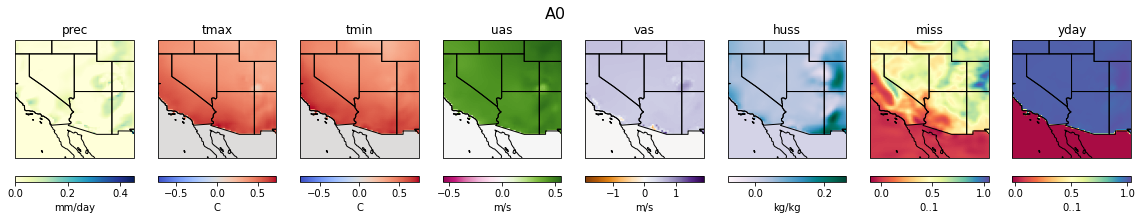

In [1956]:
vmin = [A0.detach().numpy()[0,ii].min() for ii in range(16)]
vmax = [A0.detach().numpy()[0,ii].max() for ii in range(16)]

plot_64x64_8v_abs_surf(A0[0].detach().numpy(), 'A0', vmin, vmax, 32, 32, cc=False)


In [1831]:
# 64x64 mask
yoff = 32
xoff = 32
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask64 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))[:,yoff:yoff+64,xoff:xoff+64]
mask64np = np.array(mask64[0])
mask64np[mask64np>0] = 1
mask64np[np.isnan(mask64np)] = 0.


# Plot borders
lon = mask64[0].lon
lat = mask64[0].lat



0 U850


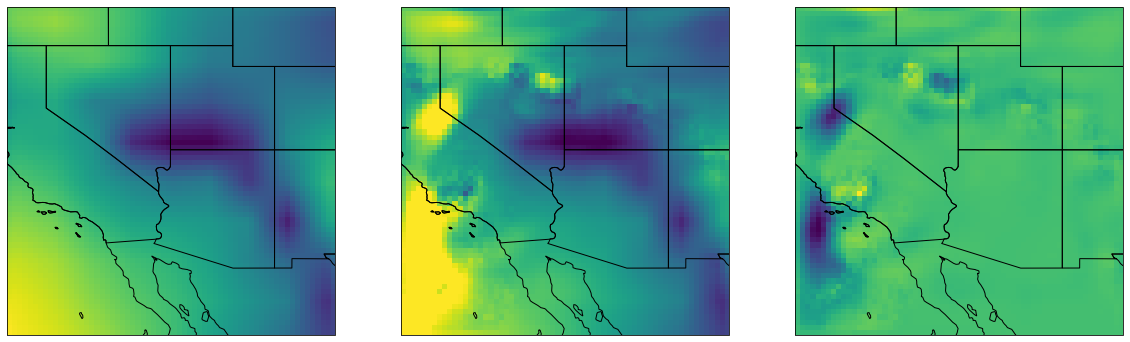

1 V850


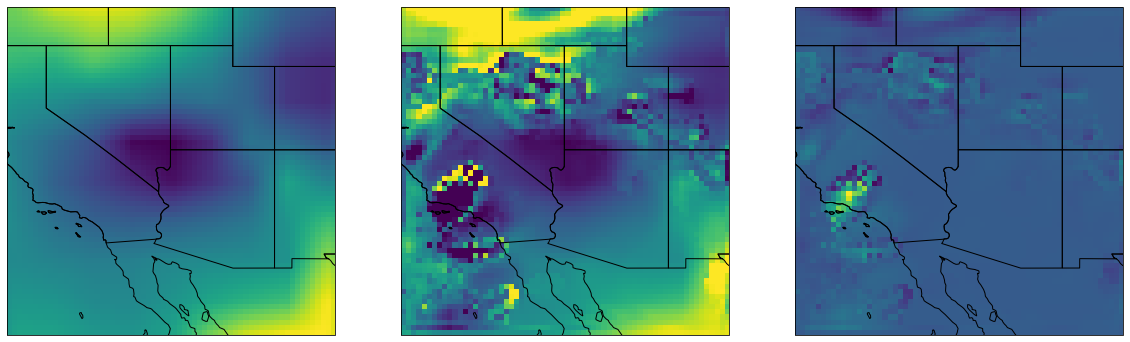

2 Q850


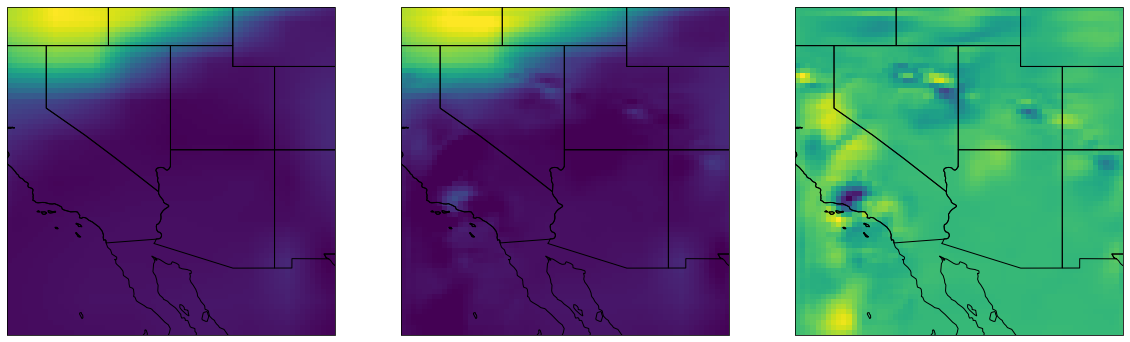

3 T700


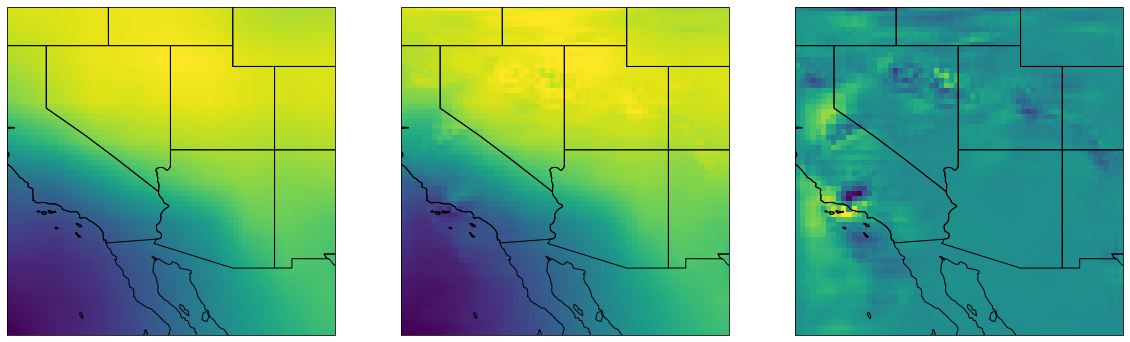

4 Z700


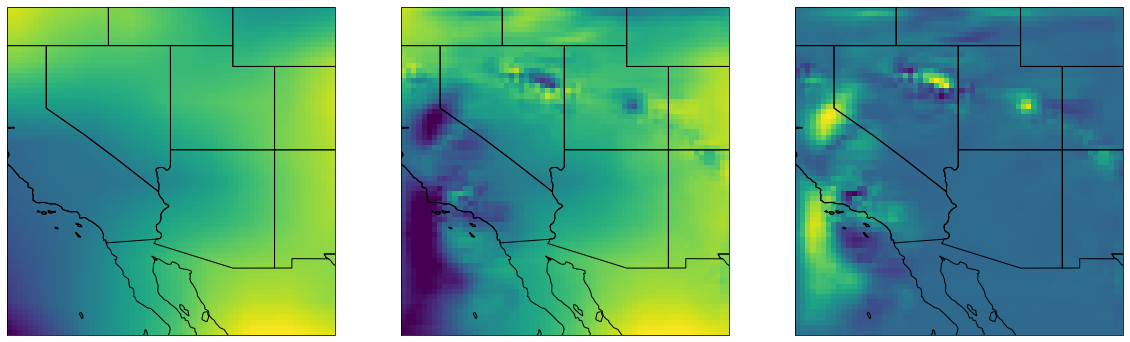

5 Z500


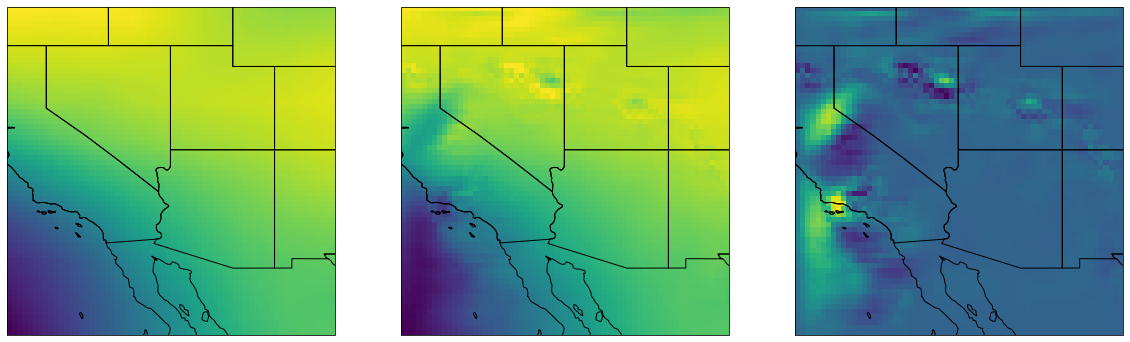

6 U250


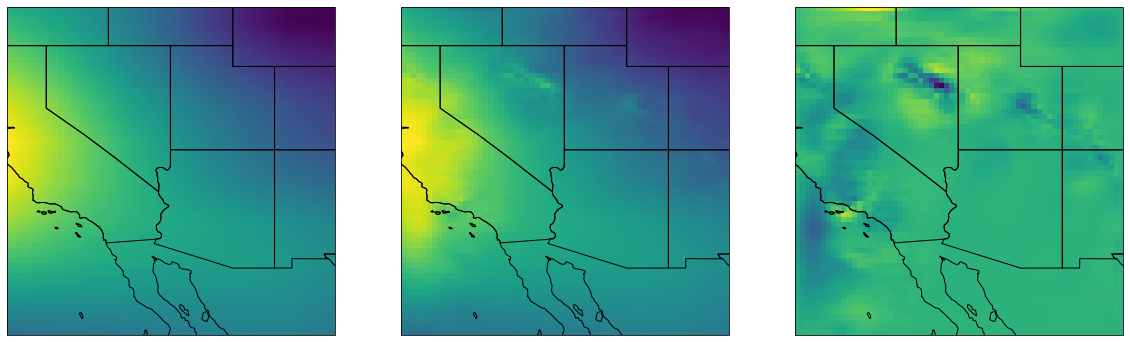

7 V250


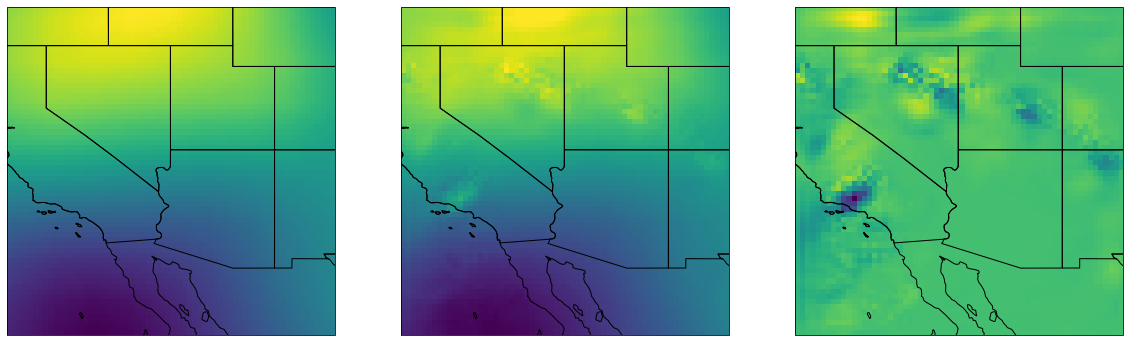

8 prec


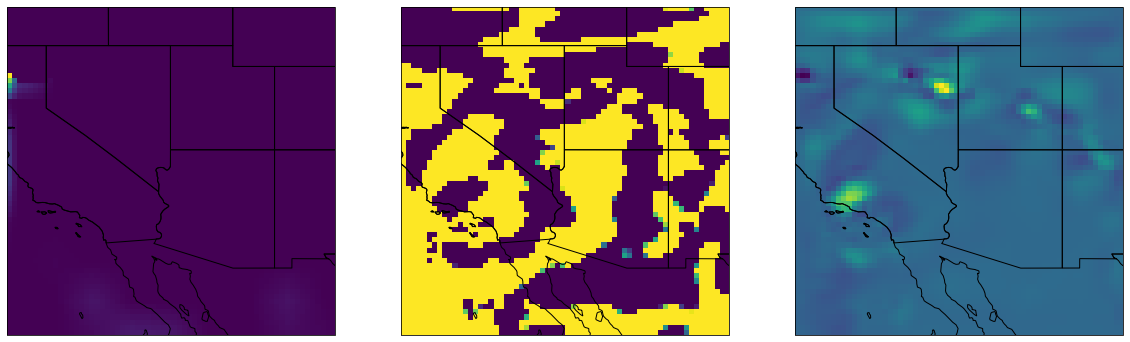

9 tmax


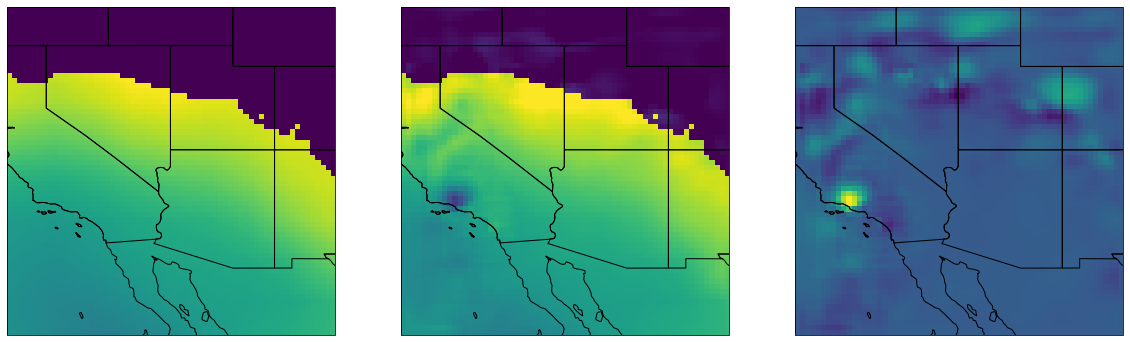

10 tmin


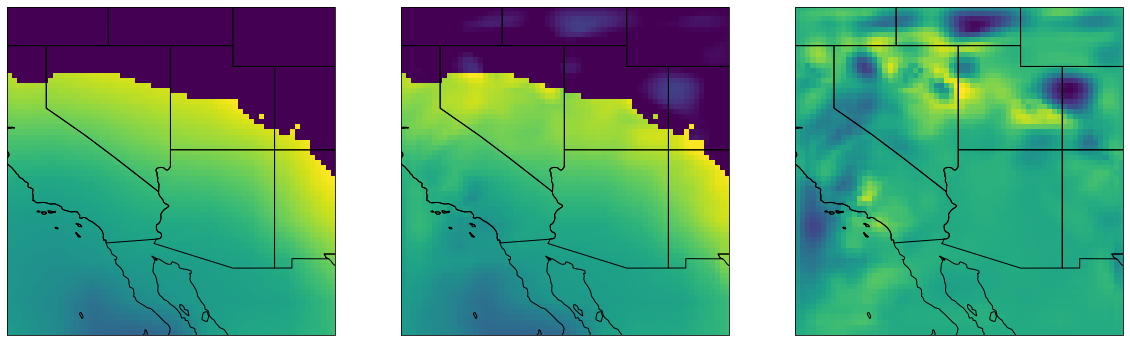

11 uas


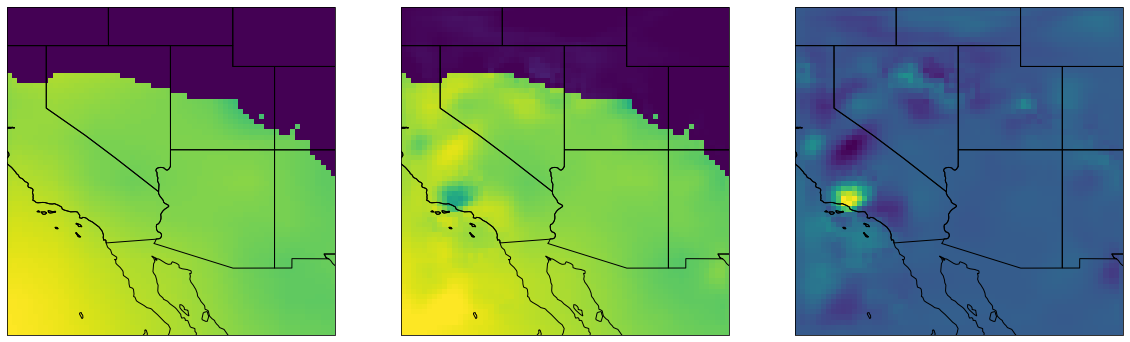

12 vas


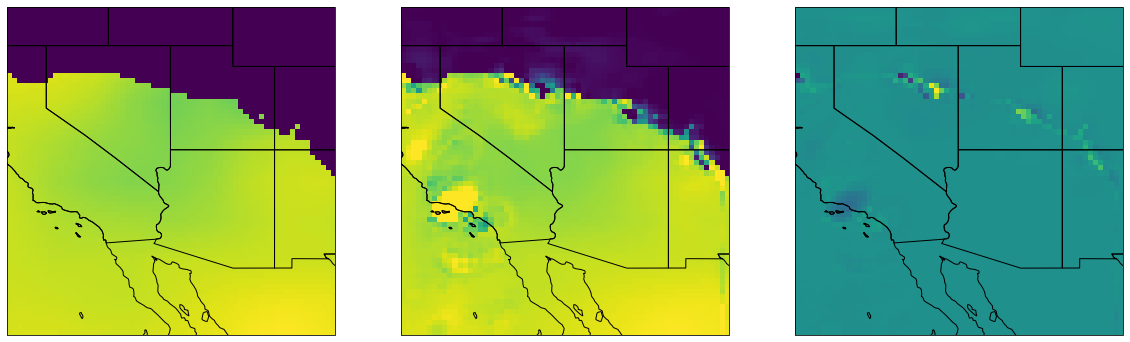

13 huss


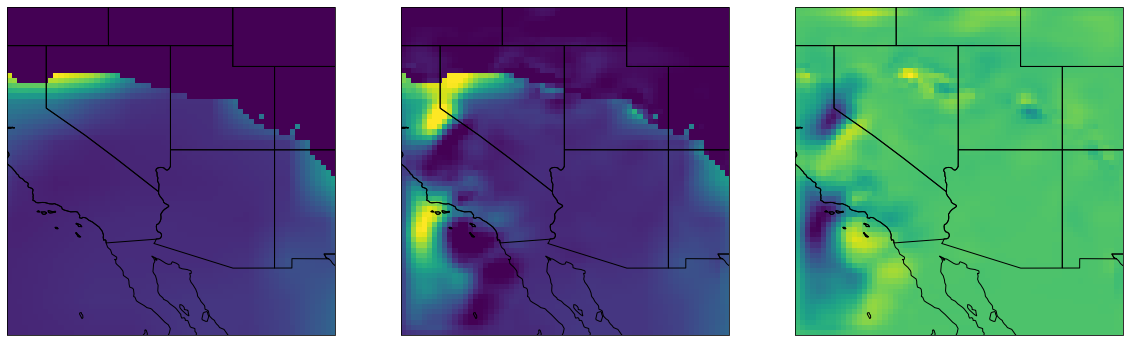

14 miss


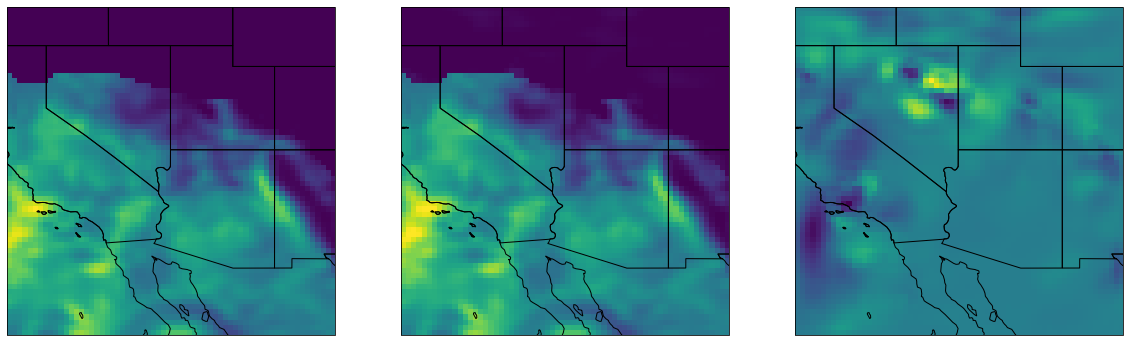

15 yday


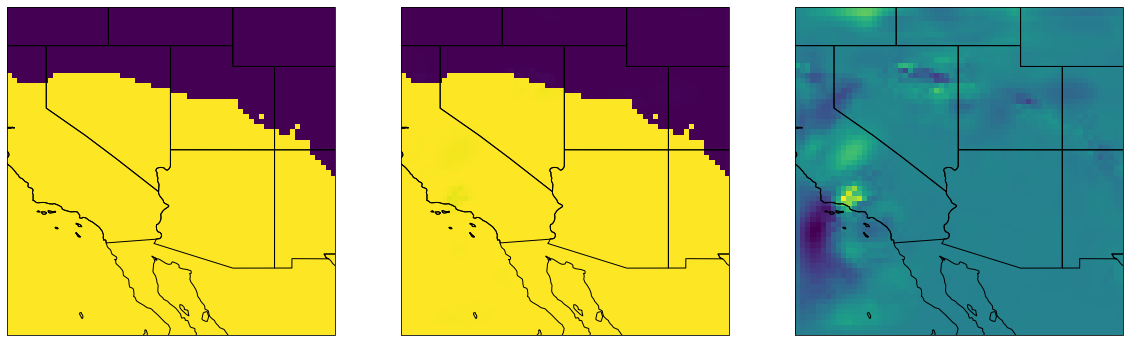

In [1957]:
# DCGAN 4 layer Discriminator
varnames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250', 'prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'miss', 'yday']

for ii in range(16):
    print(ii, varnames[ii])
    fig, axarr = plt.subplots(1, 3, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    oo = samples_mpi[1:2, :, 0+32:64+32, 0+32:64+32].detach().numpy()
    #oo = samples_mpi[180:181, :, 0+32:64+32, 0+32:64+32].detach().numpy()
    
    vmin = [oo[0,ii].min() for ii in range(16)]
    vmax = [oo[0,ii].max() for ii in range(16)]

    
    # col1
    axarr[0].coastlines()
    axarr[0].add_feature(cfeature.STATES)
    img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
    plot = axarr[0].imshow(oo[0,ii,:,::-1], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
    
    # col2
    axarr[1].coastlines()
    axarr[1].add_feature(cfeature.STATES)
    img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
    #plot = axarr[1].imshow((oo - A0.grad.numpy())[0,ii,:,::-1], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())    
    plot = axarr[1].imshow(A0.detach().numpy()[0,ii,:,::-1], vmax=vmax[ii], vmin=vmin[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())    
    
    # col3
    axarr[2].coastlines()
    axarr[2].add_feature(cfeature.STATES)
    img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
    #plot = axarr[2].imshow(A0.grad.numpy()[0,ii,:,::-1], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())    
    plot = axarr[2].imshow((oo - A0.detach().numpy())[0,ii,:,::-1], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())    
    
    plt.show()